### Business Overview

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
**For many incumbent operators, retaining high profitable customers is the number one business goal.**

**To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.**

### Objective

In this project, we will 
* analyse customer-level data of a leading telecom firm, 
* build predictive models to identify customers at high risk of churn and 
* identify the main indicators of churn.

#### Churn Definition

This project is based on Indian and Southeast Asian market and fillowing **Usage-based Churn definition** will be used:

*Usage-based churn:Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.*

#### High Value Churn

In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

#### Data and Business Objective

**dataset**: The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively.

**business objective**: is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. 

####  Understanding Customer Behaviour during Churn

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

1. The **‘good’ phase**: In this phase, the customer is happy with the service and behaves as usual.

2. The **‘action’ phase**: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. The **‘churn’ phase**: In this phase, the customer is said to have churned. We define churn based on this phase.

In this project, since we are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

### Load Data and Data Cleaning

In [1]:
# import numpy and pandas
import pandas as pd
import numpy as np

# import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
# do an inline so that plt.show() is not required everytime
%matplotlib inline

# import for pre-processing
# scale (this is same as standard scalar)
from sklearn.preprocessing import scale
# label encoding
from sklearn.preprocessing import LabelEncoder

# import for model selection:
# splitting data into training and test data (validation set)
from sklearn.model_selection import train_test_split
# import for creating K-folds
from sklearn.model_selection import KFold
# import for CV using folds created
from sklearn.model_selection import cross_val_score
# import for grid search cv for Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# for deleting unused variables
import gc

# filter warnings
import os
import warnings
warnings.filterwarnings('ignore')

In [187]:
# load the telecom churn data
dfChurn = pd.read_csv('./telecom_churn_data.csv')

In [3]:
dfChurn.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [4]:
dfChurn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


#### Analysis on recharge amount data

In [188]:
# let us first extract list of columns containing recharge amount
recharge_amnt_columns =  dfChurn.columns[dfChurn.columns.str.contains('rech_amt')]

print(recharge_amnt_columns)

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'max_rech_amt_9', 'av_rech_amt_data_6',
       'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9'],
      dtype='object')


we observe from above that there are 3 set of values for
* total recharge amount,
* maximum recharge amount and 
* average recharge amount for mobile internet.

In [176]:
# let us check if there are any missing values for recharge amount
100*dfChurn.loc[:,recharge_amnt_columns].isnull().sum()/len(dfChurn)

total_rech_amt_6       0.000000
total_rech_amt_7       0.000000
total_rech_amt_8       0.000000
total_rech_amt_9       0.000000
max_rech_amt_6         0.000000
max_rech_amt_7         0.000000
max_rech_amt_8         0.000000
max_rech_amt_9         0.000000
av_rech_amt_data_6    74.846748
av_rech_amt_data_7    74.428744
av_rech_amt_data_8    73.660737
av_rech_amt_data_9    74.077741
dtype: float64

we observe that approx 74-75% values for average recharge amount for mobile internet data is missing.

In [189]:
# let us define a new column for total average recharge amount for good phase (month 6 and 7)
dfChurn['total_avg_rech_amnt_good_ph'] = (dfChurn.total_rech_amt_6 + dfChurn.total_rech_amt_7)/2

In [190]:
# create a filter for values greater than 70th percentile of total average recharge amount for good phase 
high_value_filter = dfChurn.total_avg_rech_amnt_good_ph >= dfChurn.total_avg_rech_amnt_good_ph.quantile(0.7)

In [191]:
dfChurn.total_avg_rech_amnt_good_ph.quantile(0.7)

368.5

In [192]:
# let us subset out the High Value customers
dfChurn = dfChurn.loc[high_value_filter,:]

In [193]:
# let us check how many records remain
len(dfChurn.loc[high_value_filter,:])

30011

In [194]:
# Now let us label the churned customers
# define a new column in data frame as 'churn' with value as 1 if customer has churned and 0 if customer has not churned
# Initially set all the values as 0
dfChurn['churn']= 0

In [195]:
# the following columns will be used to find the churned customers in the 9th month 
# total_ic_mou_9, total_ic_mou_9, vol_2g_mb_9 and vol_3g_mb_9
# let's check if any NA/Null values are present
ls_9 = ['total_ic_mou_9', 'total_ic_mou_9', 'vol_2g_mb_9','vol_3g_mb_9']
100*dfChurn.loc[:,ls_9].isnull().sum()/len(dfChurn)

total_ic_mou_9    0.0
total_ic_mou_9    0.0
vol_2g_mb_9       0.0
vol_3g_mb_9       0.0
dtype: float64

In [196]:
# define is_churned boolean flag for customers where above values are zero
is_churned = (dfChurn.total_ic_mou_9 == 0) & (dfChurn.total_ic_mou_9 == 0) & (dfChurn.vol_2g_mb_9 ==0)& \
(dfChurn.vol_3g_mb_9 ==0)

In [197]:
# set all such rows fulfilling is_churned condition as 1
dfChurn.loc[is_churned,'churn']=1

In [198]:
# let us check what's the % of churned customers
100*dfChurn.churn.sum()/len(is_churned)

8.930058978374596

We see that approx. 8.9% of high value customers have churned

In [199]:
# let's extract all list of 9th Month (churned month) Columns
month_9_columns =  dfChurn.columns[dfChurn.columns.str.contains('_9')]

In [200]:
# drop all columns corresponding to the attributes of churn phase
dfChurn.drop(month_9_columns,axis=1,inplace=True)

In [339]:
# let's check how many columns remain
dfChurn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30011 entries, 7 to 99997
Columns: 174 entries, mobile_number to churn
dtypes: float64(137), int64(28), object(9)
memory usage: 40.1+ MB


In [113]:
100*dfChurn.isnull().sum()/len(dfChurn.index)

mobile_number                   0.000000
circle_id                       0.000000
loc_og_t2o_mou                  0.379861
std_og_t2o_mou                  0.379861
loc_ic_t2o_mou                  0.379861
last_date_of_month_6            0.000000
last_date_of_month_7            0.103295
last_date_of_month_8            0.523142
arpu_6                          0.000000
arpu_7                          0.000000
arpu_8                          0.000000
onnet_mou_6                     1.052947
onnet_mou_7                     1.009630
onnet_mou_8                     3.125521
offnet_mou_6                    1.052947
offnet_mou_7                    1.009630
offnet_mou_8                    3.125521
roam_ic_mou_6                   1.052947
roam_ic_mou_7                   1.009630
roam_ic_mou_8                   3.125521
roam_og_mou_6                   1.052947
roam_og_mou_7                   1.009630
roam_og_mou_8                   3.125521
loc_og_t2t_mou_6                1.052947
loc_og_t2t_mou_7

#### recharge amount related variables

In [201]:
#let's again extract the recharge amount related columns
recharge_amnt_columns =  dfChurn.columns[dfChurn.columns.str.contains('rech_amt')]

recharge_amnt_columns

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'],
      dtype='object')

In [202]:
# let's check the mean variation in values for churned and non churned customers
pd.DataFrame([dfChurn.loc[dfChurn.churn==1,recharge_amnt_columns].mean()
              ,dfChurn.loc[dfChurn.churn==0,recharge_amnt_columns].mean()],index={'Non Churned','Churned'})

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8
Churned,804.469403,636.199627,261.755597,168.937313,158.159328,86.783955,226.523715,235.976832,150.238287
Non Churned,686.863562,701.823095,648.143463,171.656910,177.377227,170.330065,239.792502,251.903496,231.653408


We see that there is a significant drop in total recharge amount, max recharge amount and average recharge amount in 8th month (action phase) for churned customers.

In [203]:
# let's check the mean recharge amount parameters across 3 months
100*dfChurn.loc[:,recharge_amnt_columns].isnull().sum()/len(dfChurn.loc[:,recharge_amnt_columns])

total_rech_amt_6       0.000000
total_rech_amt_7       0.000000
total_rech_amt_8       0.000000
max_rech_amt_6         0.000000
max_rech_amt_7         0.000000
max_rech_amt_8         0.000000
av_rech_amt_data_6    62.023925
av_rech_amt_data_7    61.140915
av_rech_amt_data_8    60.834361
dtype: float64

We observe that around 60% data values for average recharge amount for data is missing, as we already have total recharge amount and max recharge amount information with us we can safely remove these columns.

In [204]:
dfChurn.drop(['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8'],axis=1,inplace=True)

In [205]:
# Let us define two new derived columns
# total recharge amount for good phase: total_rech_amt_good_ph
# max recharge amount for good phase: max_rech_amt_good_ph

dfChurn['total_rech_amt_good_ph'] = (dfChurn.total_rech_amt_6 + dfChurn.total_rech_amt_7)/2
dfChurn['max_rech_amt_good_ph'] = (dfChurn.max_rech_amt_6 + dfChurn.max_rech_amt_7)/2

# let's define additional columns as:
# total recharge amount ratio for action month: total_rech_amt_ratio
# maxium recharge amount ratio for action month: max_rech_amt_ratio
dfChurn['total_rech_amt_ratio'] = dfChurn.total_rech_amt_8/dfChurn.total_rech_amt_good_ph
dfChurn['max_rech_amt_ratio']= dfChurn.max_rech_amt_8/dfChurn.max_rech_amt_good_ph

# drop the original columns as these are not longer required
#dfChurn.drop(['total_rech_amt_6','total_rech_amt_7'
#              ,'max_rech_amt_6','max_rech_amt_7','total_rech_amt_8','max_rech_amt_8'],axis=1,inplace=True)

dfChurn.drop(['total_rech_amt_6','total_rech_amt_7'
              ,'max_rech_amt_6','max_rech_amt_7'],axis=1,inplace=True)

In [206]:
pd.DataFrame([dfChurn.loc[dfChurn.churn==1,['total_rech_amt_ratio']].mean()
              ,dfChurn.loc[dfChurn.churn==0,['total_rech_amt_ratio']].mean()],index={'Non Churned','Churned'})

,total_rech_amt_ratio
Churned,0.358711
Non Churned,0.951963


#### last day recharge amount

In [207]:
#let's extract the last day recharge amount columns
last_day_rech_amt = dfChurn.columns[dfChurn.columns.str.contains('day')]

In [208]:
# let's check the mean variation in last day  for churned and non churned customers
pd.DataFrame([dfChurn.loc[dfChurn.churn==1,last_day_rech_amt].mean()
              ,dfChurn.loc[dfChurn.churn==0,last_day_rech_amt].mean()],index={'Non Churned','Churned'})

,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8
Churned,103.521642,81.666791,37.200746
Non Churned,104.580184,107.603271,101.384984


We can see that there is a significant drop in last month recharge amount for churned customers.

In [209]:
# Let us define new derived column
# last day recharge amount for good phase: last_day_rch_amt_good_ph
dfChurn['last_day_rch_amt_good_ph'] = (dfChurn.last_day_rch_amt_6 + dfChurn.last_day_rch_amt_7)/2

# let's define a new dervied column
# last day recharge amount ratio for action month(8th month):last_day_rch_amt_ratio
dfChurn['last_day_rch_amt_ratio'] = dfChurn.last_day_rch_amt_8/dfChurn.last_day_rch_amt_good_ph

# drop the original columns as these are not longer required
# dfChurn.drop(['last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8'],axis=1,inplace=True)

dfChurn.drop(['last_day_rch_amt_6','last_day_rch_amt_7'],axis=1,inplace=True)

#### 2G and 3G usage related variables

In [210]:
#let's extract the 2G and 3G usage related columns
typ_2g_or_3g = dfChurn.columns[dfChurn.columns.str.contains('2g|3g',regex=True)]

In [211]:
#let us check the % of NA values present
dfChurn.loc[:,typ_2g_or_3g].isnull().sum()/len(dfChurn.loc[:,typ_2g_or_3g])

count_rech_2g_6    0.620239
count_rech_2g_7    0.611409
count_rech_2g_8    0.608344
count_rech_3g_6    0.620239
count_rech_3g_7    0.611409
count_rech_3g_8    0.608344
vol_2g_mb_6        0.000000
vol_2g_mb_7        0.000000
vol_2g_mb_8        0.000000
vol_3g_mb_6        0.000000
vol_3g_mb_7        0.000000
vol_3g_mb_8        0.000000
arpu_3g_6          0.620239
arpu_3g_7          0.611409
arpu_3g_8          0.608344
arpu_2g_6          0.620239
arpu_2g_7          0.611409
arpu_2g_8          0.608344
monthly_2g_6       0.000000
monthly_2g_7       0.000000
monthly_2g_8       0.000000
sachet_2g_6        0.000000
sachet_2g_7        0.000000
sachet_2g_8        0.000000
monthly_3g_6       0.000000
monthly_3g_7       0.000000
monthly_3g_8       0.000000
sachet_3g_6        0.000000
sachet_3g_7        0.000000
sachet_3g_8        0.000000
aug_vbc_3g         0.000000
jul_vbc_3g         0.000000
jun_vbc_3g         0.000000
sep_vbc_3g         0.000000
dtype: float64

We see from above that about 60% values are not available for count of recharge and average revenue for 2G/3G per user. As we aleady have 2G/3G volume usage based data available, let's drop these columns.

In [212]:
dfChurn.drop(['count_rech_2g_6','count_rech_2g_7',
              'count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8'
               ,'arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8'],axis=1,inplace=True)

In [213]:
# let's extract volume of 2G and 3G usage columns
volume_of_usage_3g_and_2g = dfChurn.columns[dfChurn.columns.str.contains('vol_2g|vol_3g',regex=True)]

In [214]:
# let's check the mean variation in volume of 2G/3G usage for churned and non churned customers
pd.DataFrame([dfChurn.loc[dfChurn.churn==1,volume_of_usage_3g_and_2g].mean()
              ,dfChurn.loc[dfChurn.churn==0,volume_of_usage_3g_and_2g].mean()],index={'Non Churned','Churned'})

,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8
Churned,59.274616,47.704295,14.886716,184.455866,154.672840,55.426877
Non Churned,80.779398,81.158898,74.535804,265.642715,290.196039,290.891215


We have two observations from above:
* the 2G and 3G usage for churned customers drops in 8th month 
* we also see that average 3G usage is higher for non-churned customers indicating that churned customers might be from areas where 3G service is not properly available.

In [215]:
# Let us define two new derived columns
# 2G volume usage for good phase: vol_2g_mb_good_ph
# 3G volume usage for good phase: vol_3g_mb_good_ph
dfChurn['vol_2g_mb_good_ph'] = (dfChurn.vol_2g_mb_6 + dfChurn.vol_2g_mb_7)/2
dfChurn['vol_3g_mb_good_ph'] = (dfChurn.vol_3g_mb_6 + dfChurn.vol_3g_mb_7)/2

# let' define two new derived columns
# 2G volume usage ratio for action month (8th month):vol_2g_mb_ratio
# 3G volume usage ratio for action month (8th month):vol_3g_mb_ratio
dfChurn['vol_2g_mb_ratio'] = dfChurn.vol_2g_mb_8/dfChurn.vol_2g_mb_good_ph
dfChurn['vol_3g_mb_ratio'] = dfChurn.vol_3g_mb_8/dfChurn.vol_3g_mb_good_ph


# drop the original columns as these are not longer required
# dfChurn.drop(['vol_2g_mb_6','vol_2g_mb_7'
#               ,'vol_3g_mb_6','vol_3g_mb_7','vol_2g_mb_8','vol_3g_mb_8'],axis=1,inplace=True)


dfChurn.drop(['vol_2g_mb_6','vol_2g_mb_7'
              ,'vol_3g_mb_6','vol_3g_mb_7'],axis=1,inplace=True)

In [216]:
# let's check monthly 2G/3G service schemes
monthly_2g_3g = dfChurn.columns[dfChurn.columns.str.contains('monthly_2g|monthly_3g',regex=True)]

In [217]:
# let's check the mean variation in monthly schemes of 2G/3G usage for churned and non churned customers
pd.DataFrame([dfChurn.loc[dfChurn.churn==1,monthly_2g_3g].mean()
              ,dfChurn.loc[dfChurn.churn==0,monthly_2g_3g].mean()],index={'Non Churned','Churned'})

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
Churned,0.059328,0.048507,0.015299,0.131343,0.099254,0.033209
Non Churned,0.131279,0.139475,0.123742,0.178076,0.193553,0.186931


Again we see a drop in monthly subscription for churned customers in action month (8th month) as compared ot non churned customers.

In [218]:
# Let us define two new derived columns
# 2G monthly for good phase: monthly_2g_good_ph
# 3G monthly for good phase: monthly_3g_good_ph
dfChurn['monthly_2g_good_ph'] = (dfChurn.monthly_2g_6 + dfChurn.monthly_2g_7)/2
dfChurn['monthly_3g_good_ph'] = (dfChurn.monthly_3g_6 + dfChurn.monthly_3g_7)/2

# let's define two new derived columns
# 2G monthly ratio for action month (8th month):monthly_2g_ratio
# 3G monthly ratio for action month (8th month):monthly_3g_ratio
dfChurn['monthly_2g_ratio'] = dfChurn.monthly_2g_8/dfChurn.monthly_2g_good_ph
dfChurn['monthly_3g_ratio'] = dfChurn.monthly_3g_8/dfChurn.monthly_3g_good_ph

# drop the original columns as these are not longer required
# dfChurn.drop(['monthly_2g_6','monthly_2g_7'
#               ,'monthly_3g_6','monthly_3g_7','monthly_2g_8','monthly_3g_8'],axis=1,inplace=True)

dfChurn.drop(['monthly_2g_6','monthly_2g_7'
              ,'monthly_3g_6','monthly_3g_7'],axis=1,inplace=True)

#### volume based cost

In [219]:
# let us rename month named vbc columns to 6,7,8,9 format
dfChurn.rename(columns={'jun_vbc_3g':'6_vbc_3g','jul_vbc_3g':'7_vbc_3g','aug_vbc_3g':'8_vbc_3g'
                         ,'sep_vbc_3g':'9_vbc_3g'}, inplace=True)

# drop 9th month column as it is not needed
dfChurn.drop('9_vbc_3g',axis=1,inplace=True)

In [220]:
# let's check the volumne based cost for 3G
volumn_based_cost_3g = dfChurn.columns[dfChurn.columns.str.contains('vbc_3g')]

pd.DataFrame([dfChurn.loc[dfChurn.churn==1,volumn_based_cost_3g].mean()
              ,dfChurn.loc[dfChurn.churn==0,volumn_based_cost_3g].mean()],index={'Non Churned','Churned'})

,8_vbc_3g,7_vbc_3g,6_vbc_3g
Churned,32.117082,70.282698,80.198026
Non Churned,138.982798,141.485560,125.396828


We can clearly see that volumne based cost for 3G is much lower higher for Churned customers as compared to Non-Churned Customers and laso there is a drop in vbc in 8th month.

In [221]:
# Let us define new derived columns
# 3g volume based cost for good phase: vbc_3g_good_ph
dfChurn['vbc_3g_good_ph'] = (dfChurn['6_vbc_3g'] + dfChurn['7_vbc_3g'])/2

# define new column for vbc ratio in action month: vbc_3g_ratio
dfChurn['vbc_3g_ratio'] = dfChurn['8_vbc_3g']/dfChurn['vbc_3g_good_ph'] 

# drop the original columns as these are not longer required
# dfChurn.drop(['6_vbc_3g','7_vbc_3g','8_vbc_3g'],axis=1,inplace=True)

dfChurn.drop(['6_vbc_3g','7_vbc_3g'],axis=1,inplace=True)

#### sachet subscription

In [222]:
# let's check sachet subscription for 2G/3G
sachet_2g_or_3g = dfChurn.columns[dfChurn.columns.str.contains('sachet_2g|sachet_3g',regex=True)]

pd.DataFrame([dfChurn.loc[dfChurn.churn==1,sachet_2g_or_3g].mean()
              ,dfChurn.loc[dfChurn.churn==0,sachet_2g_or_3g].mean()],index={'Non Churned','Churned'})

,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
Churned,0.433582,0.415672,0.188060,0.130970,0.143284,0.042910
Non Churned,0.506934,0.604003,0.648751,0.138597,0.150891,0.149976


There is a steep drop in sachet services in 8th month for churned cutsomers as compared to non churned customers

In [223]:
# Let us define two new derived columns
# 2G sachet for good phase: sachet_2g_good_ph
# 3G sachet for good phase: sachet_3g_good_ph
dfChurn['sachet_2g_good_ph'] = (dfChurn.sachet_2g_6 + dfChurn.sachet_2g_7)/2
dfChurn['sachet_3g_good_ph'] = (dfChurn.sachet_3g_6 + dfChurn.sachet_3g_7)/2

# Let us define two new derived columns
# 2G sachet ratio for action month: sachet_2g_ratio
# 3G sachet ratio for action month: sachet_3g_ratio
dfChurn['sachet_2g_ratio'] = dfChurn.sachet_2g_8/dfChurn.sachet_2g_good_ph
dfChurn['sachet_3g_ratio'] = dfChurn.sachet_3g_8/dfChurn.sachet_3g_good_ph

# drop the original columns as these are not longer required
# dfChurn.drop(['sachet_2g_6','sachet_2g_7'
#               ,'sachet_3g_6','sachet_3g_7','sachet_2g_8','sachet_3g_8'],axis=1,inplace=True)

dfChurn.drop(['sachet_2g_6','sachet_2g_7'
              ,'sachet_3g_6','sachet_3g_7','sachet_2g_8','sachet_3g_8'],axis=1,inplace=True)

#### Age on network

In [404]:
# let's check the age on n/w for churned and non churned customers
print(dfChurn.loc[dfChurn.churn==1,'aon'].mean())
print(dfChurn.loc[dfChurn.churn==0,'aon'].mean())

869.2364057076745
1301.4048435334453


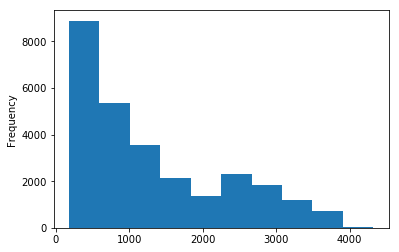

In [200]:
# let's check the age distribution for non churned customers
dfChurn.loc[dfChurn.churn==0,'aon'].plot.hist()

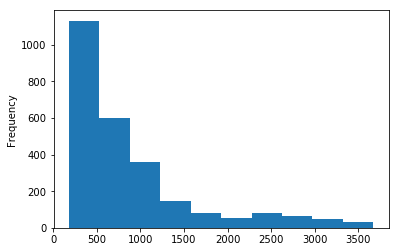

In [201]:
# let's check the age distribution for churned customers
dfChurn.loc[dfChurn.churn==1,'aon'].plot.hist()

We see from above that most of the churn cases are happening before age 1500 days.

In [224]:
# let's check the circle id values
dfChurn.circle_id.unique()

# let's drop this column as there is only one circle id
dfChurn.drop('circle_id',inplace=True,axis=1)

#### date related variables

In [228]:
# extract the date columns
date_columns = dfChurn.columns[dfChurn.columns.str.contains('date')]

# convert to datetime
for date_col in list(date_columns):
    dfChurn[date_col]= pd.to_datetime(dfChurn[date_col])

In [ ]:
print(dfChurn.last_date_of_month_6.dt.day.unique(),dfChurn.last_date_of_month_7.dt.day.unique()
      ,dfChurn.last_date_of_month_8.dt.day.unique())

# as only 1 unique value last day of month is present these columns are not adding much information
# let us drop the columns
dfChurn.drop(['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'],axis=1,inplace=True)

In [229]:
# let's extract the day of last recharge
dfChurn['day_of_last_rech_6'] =  dfChurn.date_of_last_rech_6.dt.day
dfChurn['day_of_last_rech_7'] =  dfChurn.date_of_last_rech_7.dt.day
dfChurn['day_of_last_rech_8'] =  dfChurn.date_of_last_rech_8.dt.day

dt_of_last_rech_cols = ['day_of_last_rech_6','day_of_last_rech_7','day_of_last_rech_8']

pd.DataFrame([dfChurn.loc[dfChurn.churn==1,dt_of_last_rech_cols].median()
              ,dfChurn.loc[dfChurn.churn==0,dt_of_last_rech_cols].median()],index={'Non Churned','Churned'})

,day_of_last_rech_6,day_of_last_rech_7,day_of_last_rech_8
Churned,29.0,28.0,26.0
Non Churned,28.0,29.0,29.0


We can see that the median value for last recharge is bit lower for churned customers

In [230]:
# let's define a new derived column indicating the shift in day of last recharge

dfChurn['day_of_last_rech_shift'] = dfChurn.day_of_last_rech_8 -(dfChurn.day_of_last_rech_6+dfChurn.day_of_last_rech_7)/2

In [231]:
# let's check how the shift indicates pattern for Churned and non churn customers
pd.DataFrame([dfChurn.loc[dfChurn.churn==1,['day_of_last_rech_shift']].median()
              ,dfChurn.loc[dfChurn.churn==0,['day_of_last_rech_shift']].median()],index={'Non Churned','Churned'})

,day_of_last_rech_shift
Churned,-2.0
Non Churned,0.5


We can clearly see that a large negative shift is highly indicative of churn

In [232]:
# let's delete the other colummns derived as are no longer required
dfChurn.drop(['day_of_last_rech_6','day_of_last_rech_7','day_of_last_rech_8'],axis=1,inplace=True)

In [233]:
# let's extract the day of last recharge for data
dfChurn['day_of_last_rech_data_6'] =  dfChurn.date_of_last_rech_data_6.dt.day
dfChurn['day_of_last_rech_data_7'] =  dfChurn.date_of_last_rech_data_7.dt.day
dfChurn['day_of_last_rech_data_8'] =  dfChurn.date_of_last_rech_data_8.dt.day

dt_of_last_rech_cols = ['day_of_last_rech_data_6','day_of_last_rech_data_7','day_of_last_rech_data_8']

pd.DataFrame([dfChurn.loc[dfChurn.churn==1,dt_of_last_rech_cols].median()
              ,dfChurn.loc[dfChurn.churn==0,dt_of_last_rech_cols].median()],index={'Non Churned','Churned'})

,day_of_last_rech_data_6,day_of_last_rech_data_7,day_of_last_rech_data_8
Churned,21.0,20.0,15.5
Non Churned,21.0,23.0,22.0


In [234]:
# let's define a new derived column indicating the shift in day of last data recharge

dfChurn['day_of_last_rech_data_shift'] = dfChurn.day_of_last_rech_data_8 -(dfChurn.day_of_last_rech_data_6+dfChurn.day_of_last_rech_data_7)/2

In [235]:
# let's check how the shift indicates pattern for Churned and non churn customers
pd.DataFrame([dfChurn.loc[dfChurn.churn==1,['day_of_last_rech_data_shift']].median()
              ,dfChurn.loc[dfChurn.churn==0,['day_of_last_rech_data_shift']].median()],index={'Non Churned','Churned'})

,day_of_last_rech_data_shift
Churned,-5.0
Non Churned,-0.5


In [236]:
# let's delete the other colummns derived as are no longer required
dfChurn.drop(['day_of_last_rech_data_6','day_of_last_rech_data_7','day_of_last_rech_data_8'],axis=1,inplace=True)

In [237]:
# let us drop the date columns as we have derived day of month variables from them
dfChurn.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'],axis=1,inplace=True)
dfChurn.drop(['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'],axis=1,inplace=True)

In [96]:
dfChurn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30011 entries, 7 to 99997
Columns: 141 entries, mobile_number to day_of_last_rech_data_shift
dtypes: float64(135), int64(6)
memory usage: 33.8 MB


#### average revenue per user

In [238]:
# extract columns for average revenue per user
arpu_cols = dfChurn.columns[dfChurn.columns.str.contains('arpu_')]

# check mean variation across months 6,7 and 8
pd.DataFrame([dfChurn.loc[dfChurn.churn==1,arpu_cols].median()
              ,dfChurn.loc[dfChurn.churn==0,arpu_cols].median()],index={'Non Churned','Churned'})

,arpu_6,arpu_7,arpu_8
Churned,571.6295,464.6875,109.237
Non Churned,489.2400,496.3560,471.584


We can see that arpu also drops signficantly in action phase for churned customers

In [239]:
# Let us define new derived columns
# arpu for good phase: arpu_good_ph
dfChurn['arpu_good_ph'] = (dfChurn.arpu_6 + dfChurn.arpu_7)/2

# let's define new derived column
# average revenue per user ration for action month: arpu_ratio
dfChurn['arpu_ratio'] = dfChurn.arpu_8/dfChurn.arpu_good_ph

# drop the original columns as these are not longer required
# dfChurn.drop(['arpu_6','arpu_7','arpu_8'],axis=1,inplace=True)


dfChurn.drop(['arpu_6','arpu_7'],axis=1,inplace=True)

#### Minutes of Usage related variables

In [240]:
# let's derive minutes of usage columns
mou_cols = dfChurn.columns[dfChurn.columns.str.contains('mou')]

In [102]:
mou_cols

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
       'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7',
       'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_o

In [241]:
# let's check if there are any zero variation columns among these
zero_var_cols = dfChurn.loc[:,mou_cols].std()[dfChurn.loc[:,mou_cols].std()==0].index.values

zero_var_cols

array(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'], dtype=object)

In [ ]:
# let's drop these columns
dfChurn.drop(list(zero_var_cols),axis=1,inplace=True)

In [245]:
# let's check the 5 of null values among mou variables
mou_cols = dfChurn.columns[dfChurn.columns.str.contains('mou')]
100*dfChurn.loc[:,mou_cols].isnull().sum()/len(dfChurn.loc[:,mou_cols])

onnet_mou_6         1.052947
onnet_mou_7         1.009630
onnet_mou_8         3.125521
offnet_mou_6        1.052947
offnet_mou_7        1.009630
offnet_mou_8        3.125521
roam_ic_mou_6       1.052947
roam_ic_mou_7       1.009630
roam_ic_mou_8       3.125521
roam_og_mou_6       1.052947
roam_og_mou_7       1.009630
roam_og_mou_8       3.125521
loc_og_t2t_mou_6    1.052947
loc_og_t2t_mou_7    1.009630
loc_og_t2t_mou_8    3.125521
loc_og_t2m_mou_6    1.052947
loc_og_t2m_mou_7    1.009630
loc_og_t2m_mou_8    3.125521
loc_og_t2f_mou_6    1.052947
loc_og_t2f_mou_7    1.009630
loc_og_t2f_mou_8    3.125521
loc_og_t2c_mou_6    1.052947
loc_og_t2c_mou_7    1.009630
loc_og_t2c_mou_8    3.125521
loc_og_mou_6        1.052947
loc_og_mou_7        1.009630
loc_og_mou_8        3.125521
std_og_t2t_mou_6    1.052947
std_og_t2t_mou_7    1.009630
std_og_t2t_mou_8    3.125521
                      ...   
loc_ic_t2m_mou_6    1.052947
loc_ic_t2m_mou_7    1.009630
loc_ic_t2m_mou_8    3.125521
loc_ic_t2f_mou

In [246]:
# let's check the maximum % of missing value
100*dfChurn.loc[:,mou_cols].isnull().sum().max()/len(dfChurn.loc[:,mou_cols])

3.1255206424311086

So for all minutes of usage columns the maximu, missing % is 3.12 which seems that in these case the mobile has not been used at all for that particular call type(ic,std etc.), thus it is safe to assume that we can impute the missing values with zero.

In [247]:
# replaceing null values by 0 for minutes of usage variables
dfChurn.loc[:,mou_cols] = dfChurn.loc[:,mou_cols].replace(np.NaN,0)

100*dfChurn.loc[:,mou_cols].isnull().sum().max()/len(dfChurn.loc[:,mou_cols])

0.0

Lets now now analyze the sub groups of minutes of usage, following groups are there:
* og: outgoing calls
* ic: incoming calls
* offnet: all kinds of calls outside operator network
* onnet: all kinds of call within same operator network

Let us start by analyzing minutes for usage variables for month 6

In [248]:
# let's collect mou variables for month 6
mou_6 = dfChurn.columns[dfChurn.columns.str.contains('mou_6')]

In [113]:
mou_6

Index(['onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6',
       'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6',
       'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6',
       'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6', 'isd_og_mou_6',
       'spl_og_mou_6', 'total_og_mou_6', 'loc_ic_t2t_mou_6',
       'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6',
       'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6',
       'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6'],
      dtype='object')

Let's check the outgoing mou variables.

In [249]:
mou_og_cols6 = dfChurn.columns[dfChurn.columns.str.contains('.*_og_.*mou_6',regex=True)]

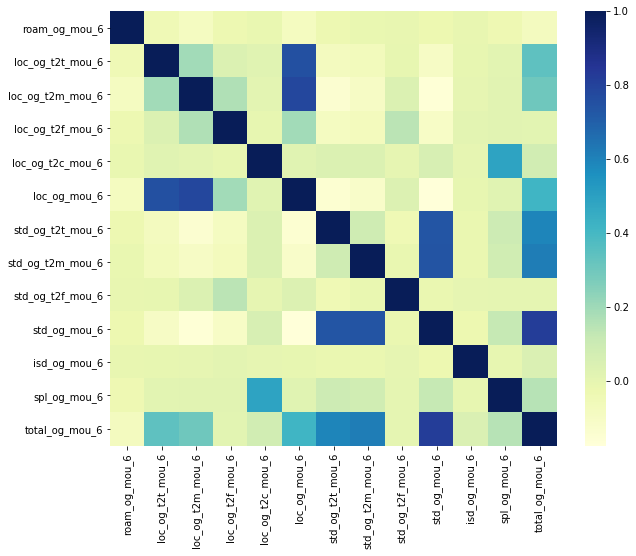

In [124]:
#sns.heatmap(dfChurn.loc[:,mou_cols6].corr())

# let us create a correlation matrix heatmap among quantitative varibales
plt.figure(figsize=(10, 8))
sns.heatmap(dfChurn.loc[:,mou_ic_cols6].corr(), cmap="YlGnBu")
plt.show()

After analyzing the variables, we acertain the following rlationships among variables: 

* **total_og_mou_6 = loc_og_mou_6+std_og_mou_6+spl_og_mou_6+isd_og_mou_6+ roam_og_mou_6**
* **std_og_mou_6 = std_og_t2m_mou_6+std_og_t2t_mou_6+std_og_t2f_mou_6 + std_og_2tc_mou_6**
* **loc_og_mou_6 = loc_og_t2m_mou_6+loc_og_t2t_mou_6+loc_og_t2f_mou_6 + loc_og_2tc_mou_6**

In [142]:
## fact checking!!
print(dfChurn.loc[7,'total_og_mou_6'],dfChurn.loc[7,['loc_og_mou_6','std_og_mou_6','spl_og_mou_6','isd_og_mou_6']].sum())

print(dfChurn.loc[7,'std_og_mou_6'],dfChurn.loc[7,['std_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2f_mou_6','std_og_loc_mou_6']].sum())

print(dfChurn.loc[7,'loc_og_mou_6'],dfChurn.loc[7,['loc_og_t2m_mou_6','loc_og_t2t_mou_6','loc_og_t2f_mou_6','loc_og_2tc_mou_6']].sum())

487.53 487.52000000000004
60.86 60.849999999999994
422.16 422.15


In [250]:
# As total_og_mou_6, std_og_mou_6 and loc_og_mou_6 already have component variables present in dataset
# let's remove these columns for all months from the data set

ls_total_og_cols = dfChurn.columns[dfChurn.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)]

print(ls_total_og_cols)

dfChurn.drop(ls_total_og_cols,axis=1,inplace=True)

Index(['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6',
       'std_og_mou_7', 'std_og_mou_8', 'total_og_mou_6', 'total_og_mou_7',
       'total_og_mou_8'],
      dtype='object')


In [251]:
# let's define good phase derive variables for all og components:
dfChurn['spl_og_mou_good_ph'] = (dfChurn.spl_og_mou_6 + dfChurn.spl_og_mou_7)/2
dfChurn['isd_og_mou_good_ph'] = (dfChurn.isd_og_mou_6 + dfChurn.isd_og_mou_7)/2
dfChurn['roam_og_mou_good_ph'] = (dfChurn.roam_og_mou_6 + dfChurn.roam_og_mou_7)/2
dfChurn['std_og_t2m_mou_good_ph'] = (dfChurn.std_og_t2m_mou_6 + dfChurn.std_og_t2m_mou_7)/2
dfChurn['std_og_t2t_mou_good_ph'] = (dfChurn.std_og_t2t_mou_6 + dfChurn.std_og_t2t_mou_7)/2
dfChurn['std_og_t2f_mou_good_ph'] = (dfChurn.std_og_t2f_mou_6 + dfChurn.std_og_t2f_mou_7)/2

dfChurn['loc_og_t2m_mou_good_ph'] = (dfChurn.loc_og_t2m_mou_6 + dfChurn.loc_og_t2m_mou_7)/2
dfChurn['loc_og_t2t_mou_good_ph'] = (dfChurn.loc_og_t2t_mou_6 + dfChurn.loc_og_t2t_mou_7)/2
dfChurn['loc_og_t2f_mou_good_ph'] = (dfChurn.loc_og_t2f_mou_6 + dfChurn.loc_og_t2f_mou_7)/2


# let's define ratio of mou for action month based on previous month's average usage
dfChurn['spl_og_mou_ratio'] = dfChurn.spl_og_mou_8/dfChurn.spl_og_mou_good_ph
dfChurn['isd_og_mou_ratio'] = dfChurn.isd_og_mou_8/dfChurn.isd_og_mou_good_ph
dfChurn['roam_og_mou_ratio'] = dfChurn.roam_og_mou_8/dfChurn.roam_og_mou_good_ph
dfChurn['std_og_t2m_mou_ratio'] = dfChurn.std_og_t2m_mou_8/dfChurn.std_og_t2m_mou_good_ph
dfChurn['std_og_t2t_mou_ratio'] = dfChurn.std_og_t2t_mou_8/dfChurn.std_og_t2t_mou_good_ph
dfChurn['std_og_t2f_mou_ratio'] = dfChurn.std_og_t2f_mou_8/dfChurn.std_og_t2f_mou_good_ph

dfChurn['loc_og_t2m_mou_ratio'] = dfChurn.loc_og_t2m_mou_8/dfChurn.loc_og_t2m_mou_good_ph
dfChurn['loc_og_t2t_mou_good_ph'] = dfChurn.loc_og_t2t_mou_8/dfChurn.loc_og_t2t_mou_good_ph
dfChurn['loc_og_t2f_mou_good_ph'] = dfChurn.loc_og_t2f_mou_8/dfChurn.loc_og_t2f_mou_good_ph

In [252]:
# drop all the original og mou variables
ls_og = dfChurn.columns[dfChurn.columns.str.contains('.*_og_.*mou_6|.*_og_.*mou_7|.*_og_.*mou_8',regex=True)]

print(ls_og)

dfChurn.drop(ls_og,axis=1,inplace=True)

Index(['roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'isd_og_mou_6', 'isd_og_mou_7',
       'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8'],
      dtype='object')


**Let's check for incoming mou variables**

In [253]:
mou_ic_cols6 = dfChurn.columns[dfChurn.columns.str.contains('.*_ic_.*mou_6',regex=True)]

mou_ic_cols6

Index(['roam_ic_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6',
       'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6',
       'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6',
       'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6'],
      dtype='object')

As with ic mou variables above, we observe the following relationship among ic (incoming)mou variables:

* **total_ic_mou_6 = loc_ic_mou_6 + std_ic_mou_6 + roam_ic_mou_6 + isd_ic_mou_6 + spl_ic_mou_6**
* **loc_ic_mou_6 = loc_ic_t2t_mou_6 + loc_ic_t2m_mou_6+loc_ic_t2f_mou_6+loc_ic_t2c_mou_6**
* **std_ic_mou_6 = std_ic_t2t_mou_6 + std_ic_t2m_mou_6 + std_ic_t2f_mou_6+std_ic_t2c_mou_6**

In [141]:
# fact checking!!
print(dfChurn.loc[7,'total_ic_mou_6'],dfChurn.loc[7,['loc_ic_mou_6','roam_ic_mou_6','isd_ic_mou_6','spl_ic_mou_6','std_ic_mou_6']].sum())

print(dfChurn.loc[7,'loc_ic_mou_6'],dfChurn.loc[7,['loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','loc_ic_t2c_mou_6']].sum())

print(dfChurn.loc[7,'std_ic_mou_6'],dfChurn.loc[7,['std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6','std_ic_t2c_mou_6']].sum())

626.46 626.92
427.88 427.86
180.54 180.51999999999998


In [254]:
# As total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 already have component variables present in dataset
# let's remove these columns for all months from the data set

ls_total_ic_cols = dfChurn.columns[dfChurn.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)]

print(ls_total_ic_cols)

dfChurn.drop(ls_total_ic_cols,axis=1,inplace=True)

Index(['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6',
       'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7',
       'total_ic_mou_8'],
      dtype='object')


In [255]:
# let's define good phase derive variables for all ic components:
dfChurn['spl_ic_mou_good_ph'] = (dfChurn.spl_ic_mou_6 + dfChurn.spl_ic_mou_7)/2
dfChurn['isd_ic_mou_good_ph'] = (dfChurn.isd_ic_mou_6 + dfChurn.isd_ic_mou_7)/2
dfChurn['roam_ic_mou_good_ph'] = (dfChurn.roam_ic_mou_6 + dfChurn.roam_ic_mou_7)/2
dfChurn['std_ic_t2m_mou_good_ph'] = (dfChurn.std_ic_t2m_mou_6 + dfChurn.std_ic_t2m_mou_7)/2
dfChurn['std_ic_t2t_mou_good_ph'] = (dfChurn.std_ic_t2t_mou_6 + dfChurn.std_ic_t2t_mou_7)/2
dfChurn['std_ic_t2f_mou_good_ph'] = (dfChurn.std_ic_t2f_mou_6 + dfChurn.std_ic_t2f_mou_7)/2

dfChurn['loc_ic_t2m_mou_good_ph'] = (dfChurn.loc_ic_t2m_mou_6 + dfChurn.loc_ic_t2m_mou_7)/2
dfChurn['loc_ic_t2t_mou_good_ph'] = (dfChurn.loc_ic_t2t_mou_6 + dfChurn.loc_ic_t2t_mou_7)/2
dfChurn['loc_ic_t2f_mou_good_ph'] = (dfChurn.loc_ic_t2f_mou_6 + dfChurn.loc_ic_t2f_mou_7)/2


# let's define ratio of mou for action month based on previous month's average usage
dfChurn['spl_ic_mou_ratio'] = dfChurn.spl_ic_mou_8/dfChurn.spl_ic_mou_good_ph
dfChurn['isd_ic_mou_ratio'] = dfChurn.isd_ic_mou_8/dfChurn.isd_ic_mou_good_ph
dfChurn['roam_ic_mou_ratio'] = dfChurn.roam_ic_mou_8/dfChurn.roam_ic_mou_good_ph
dfChurn['std_ic_t2m_mou_ratio'] = dfChurn.std_ic_t2m_mou_8/dfChurn.std_ic_t2m_mou_good_ph
dfChurn['std_ic_t2t_mou_ratio'] = dfChurn.std_ic_t2t_mou_8/dfChurn.std_ic_t2t_mou_good_ph
dfChurn['std_ic_t2f_mou_ratio'] = dfChurn.std_ic_t2f_mou_8/dfChurn.std_ic_t2f_mou_good_ph

dfChurn['loc_ic_t2m_mou_ratio'] = dfChurn.loc_ic_t2m_mou_8/dfChurn.loc_ic_t2m_mou_good_ph
dfChurn['loc_ic_t2t_mou_good_ph'] = dfChurn.loc_ic_t2t_mou_8/dfChurn.loc_ic_t2t_mou_good_ph
dfChurn['loc_ic_t2f_mou_good_ph'] = dfChurn.loc_ic_t2f_mou_8/dfChurn.loc_ic_t2f_mou_good_ph

In [256]:
# drop all the original og mou variables
ls_ic = dfChurn.columns[dfChurn.columns.str.contains('.*_ic_.*mou_6|.*_ic_.*mou_7|.*_ic_.*mou_8',regex=True)]

print(ls_ic)

dfChurn.drop(ls_ic,axis=1,inplace=True)

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6',
       'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6',
       'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_6',
       'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_6',
       'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_6',
       'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7',
       'spl_ic_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8'],
      dtype='object')


**offnet usage**

In [257]:
 offnet_cols = dfChurn.columns[dfChurn.columns.str.contains('offnet',regex=True)]

In [258]:
# let's check the mean variation in values for churned and non churned customers
pd.DataFrame([dfChurn.loc[dfChurn.churn==1,offnet_cols].mean()
              ,dfChurn.loc[dfChurn.churn==0,offnet_cols].mean()],index={'Non Churned','Churned'})

,offnet_mou_6,offnet_mou_7,offnet_mou_8
Churned,509.885250,411.075220,154.831549
Non Churned,408.916833,425.184327,396.612909


there is a substantial decrease in offnet mou.

In [259]:
# Let us define new derived column
# minutes of usage for good phase: onnet_mou_good_ph
dfChurn['offnet_mou_good_ph'] = (dfChurn.offnet_mou_6 + dfChurn.offnet_mou_7)/2

# create a new derive column for:
# ratio of offnet calls mou for action month wrt to previous months average
dfChurn['offnet_mou_ratio'] = dfChurn.offnet_mou_8/dfChurn.offnet_mou_good_ph

# drop the original columns as these are not longer required
dfChurn.drop(['offnet_mou_6','offnet_mou_7','offnet_mou_8'],axis=1,inplace=True)

#### minutes of usage related variables within same operator network

In [260]:
#let's extract the minutes of usage related columns
onnet_cols =  dfChurn.columns[dfChurn.columns.str.contains('^onnet.*mou',regex=True)]

In [261]:
# let's check the mean variation in values for churned and non churned customers
pd.DataFrame([dfChurn.loc[dfChurn.churn==1,onnet_cols].mean()
              ,dfChurn.loc[dfChurn.churn==0,onnet_cols].mean()],index={'Non Churned','Churned'})

,onnet_mou_6,onnet_mou_7,onnet_mou_8
Churned,407.201138,315.298369,123.209060
Non Churned,285.133773,303.268974,281.759017


We again see that there is a drop in minutes of usage in the action month (8th month) for churned customers

In [262]:
# Let us define new derived column
# minutes of usage for good phase: onnet_mou_good_ph
dfChurn['onnet_mou_good_ph'] = (dfChurn.onnet_mou_6 + dfChurn.onnet_mou_7)/2

# create a new derived variable:
# ratio of onnet mou in action month wrt onnet call average in previous month
dfChurn['onnet_mou_ratio'] = dfChurn.onnet_mou_8/dfChurn.onnet_mou_good_ph

# drop the original columns as these are not longer required
dfChurn.drop(['onnet_mou_6','onnet_mou_7','onnet_mou_8'],axis=1,inplace=True)

#### Contact centre call related variables

In [263]:
#let's extract the minutes of usage related columns
call_to_contact_centre =  dfChurn.columns[dfChurn.columns.str.contains('t2c')]

In [264]:
call_to_contact_centre

Index([], dtype='object')

In [367]:
# let's check the mean variation in contact centre calls for churned and non churned customers
pd.DataFrame([dfChurn.loc[dfChurn.churn==1,call_to_contact_centre].mean()
              ,dfChurn.loc[dfChurn.churn==0,call_to_contact_centre].mean()],index={'Non Churned','Churned'})

,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8
Churned,1.766361,2.196409,1.275994,0.0,0.0,0.0
Non Churned,1.567153,1.853094,1.801569,0.0,0.0,0.0


In [373]:
dfChurn.std_ic_t2c_mou_6.std(),dfChurn.std_ic_t2c_mou_7.std(),dfChurn.std_ic_t2c_mou_8.std()

(0.0, 0.0, 0.0)

In [375]:
# Let us define new derived column
# local outgoing call to contact centre for good phase: loc_ic_t2c_mou_good_ph
dfChurn['loc_ic_t2c_mou_good_ph'] = (dfChurn.loc_ic_t2c_mou_6 + dfChurn.loc_ic_t2c_mou_7)/2

# drop the original columns as these are not longer required
dfChurn.drop(['loc_ic_t2c_mou_6','loc_ic_t2c_mou_7'],axis=1,inplace=True)

In [266]:
100*dfChurn.isnull().sum()/len(dfChurn)

mobile_number              0.000000
arpu_8                     0.000000
og_others_6                1.052947
og_others_7                1.009630
og_others_8                3.125521
ic_others_6                1.052947
ic_others_7                1.009630
ic_others_8                3.125521
total_rech_num_6           0.000000
total_rech_num_7           0.000000
total_rech_num_8           0.000000
total_rech_amt_8           0.000000
max_rech_amt_8             0.000000
last_day_rch_amt_8         0.000000
total_rech_data_6         62.023925
total_rech_data_7         61.140915
total_rech_data_8         60.834361
max_rech_data_6           62.023925
max_rech_data_7           61.140915
max_rech_data_8           60.834361
vol_2g_mb_8                0.000000
vol_3g_mb_8                0.000000
night_pck_user_6          62.023925
night_pck_user_7          61.140915
night_pck_user_8          60.834361
monthly_2g_8               0.000000
monthly_3g_8               0.000000
fb_user_6                 62